### Adi Pradhan
__Udacity MLND Final Project Nov 2018__

Kaggle competition link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

Data cleanup, munging and model training code

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fastai
import feather
import re

In [197]:
num_rows = 500_000
raw_data = pd.read_csv('../data/taxi/train.csv',parse_dates=['pickup_datetime'],nrows=num_rows)
raw_data = raw_data.drop('key',axis='columns')


In [231]:
kaggle = pd.read_csv('../data/taxi/test.csv',parse_dates=['pickup_datetime'])
kaggle = kaggle.drop('key',axis='columns')

In [198]:
train_rows = int(0.8*num_rows)

In [199]:
print(raw_data.shape)
raw_data.head(n=2).T

(500000, 7)


,0,1
fare_amount,4.5,16.9
pickup_datetime,2009-06-15 17:26:21,2010-01-05 16:52:16
pickup_longitude,-73.8443,-74.016
pickup_latitude,40.7213,40.7113
dropoff_longitude,-73.8416,-73.9793
dropoff_latitude,40.7123,40.782
passenger_count,1,1


In [200]:
raw_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [201]:
import feather
feather.write_dataframe(raw_data,'../data/taxi/train.500k.feather')

### Data Cleanup and Feature Engineering

In [202]:
raw_data = feather.read_dataframe('../data/taxi/train.500k.feather')

In [203]:
raw_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [204]:
# drop missing values and negative fares
raw_data = raw_data.dropna(how='any',axis='rows')
raw_data = raw_data[raw_data.fare_amount > 0]

In [205]:
raw_data.fare_amount.describe()

count    499960.000000
mean         11.359244
std           9.915389
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

In [206]:
per = [0.00001,0.001,0.01,0.03,0.05,0.1,0.9,0.95,0.97,0.99,0.995,0.999]
for p in per:
    print(f'The {p*100}% percentile of fare_amount is: {raw_data.fare_amount.quantile(p):.2f}')

The 0.001% percentile of fare_amount is: 1.50
The 0.1% percentile of fare_amount is: 2.50
The 1.0% percentile of fare_amount is: 3.30
The 3.0% percentile of fare_amount is: 3.70
The 5.0% percentile of fare_amount is: 4.10
The 10.0% percentile of fare_amount is: 4.50
The 90.0% percentile of fare_amount is: 20.50
The 95.0% percentile of fare_amount is: 30.50
The 97.0% percentile of fare_amount is: 38.50
The 99.0% percentile of fare_amount is: 52.10
The 99.5% percentile of fare_amount is: 57.33
The 99.9% percentile of fare_amount is: 80.00


In [207]:
raw_data = raw_data[(raw_data.fare_amount <= 52.1) & (raw_data.fare_amount > 2.5)]

In [208]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [209]:
add_datepart(raw_data,'pickup_datetime',time=True)

In [232]:
add_datepart(kaggle,'pickup_datetime',time=True)

In [210]:
raw_data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetimeYear,pickup_datetimeMonth,pickup_datetimeWeek,pickup_datetimeDay,...,pickup_datetimeIs_month_end,pickup_datetimeIs_month_start,pickup_datetimeIs_quarter_end,pickup_datetimeIs_quarter_start,pickup_datetimeIs_year_end,pickup_datetimeIs_year_start,pickup_datetimeHour,pickup_datetimeMinute,pickup_datetimeSecond,pickup_datetimeElapsed
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,25,15,...,False,False,False,False,False,False,17,26,21,1245086781
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,5,...,False,False,False,False,False,False,16,52,16,1262710336
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,33,18,...,False,False,False,False,False,False,0,35,0,1313627700
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,16,21,...,False,False,False,False,False,False,4,30,42,1334982642
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,10,9,...,False,False,False,False,False,False,7,51,0,1268121060


In [211]:
raw_data['abs_diff_lat'] = (raw_data.dropoff_latitude - raw_data.pickup_latitude).abs()
raw_data['abs_diff_lon'] = ( raw_data.dropoff_longitude - raw_data.pickup_longitude).abs()
raw_data['dist_manhattan']= raw_data.abs_diff_lat + raw_data.abs_diff_lon

In [233]:
kaggle['abs_diff_lat'] = (kaggle.dropoff_latitude - kaggle.pickup_latitude).abs()
kaggle['abs_diff_lon'] = ( kaggle.dropoff_longitude - kaggle.pickup_longitude).abs()
kaggle['dist_manhattan']= kaggle.abs_diff_lat + kaggle.abs_diff_lon

In [212]:
# Haversine 

# Radius of the earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [234]:
raw_data['haversine'] = haversine_np(raw_data['pickup_longitude'], raw_data['pickup_latitude'],
                         raw_data['dropoff_longitude'], raw_data['dropoff_latitude'])
raw_data['weekend'] = raw_data.pickup_datetimeDayofweek.apply(lambda day: 1 if (day == 5) or (day == 6) else 0)

In [235]:
kaggle['haversine'] = haversine_np(kaggle['pickup_longitude'], kaggle['pickup_latitude'],
                         kaggle['dropoff_longitude'], kaggle['dropoff_latitude'])
kaggle['weekend'] = kaggle.pickup_datetimeDayofweek.apply(lambda day: 1 if (day == 5) or (day == 6) else 0)

In [215]:
per = [0.00001,0.001,0.01,0.1,0.9,0.95,0.99,0.999]
for p in per:
    print(f'The {p*100}% percentile of distance is {raw_data.dist_manhattan.quantile(p):.2f}')

The 0.001% percentile of distance is 0.00
The 0.1% percentile of distance is 0.00
The 1.0% percentile of distance is 0.00
The 10.0% percentile of distance is 0.01
The 90.0% percentile of distance is 0.09
The 95.0% percentile of distance is 0.13
The 99.0% percentile of distance is 0.28
The 99.9% percentile of distance is 114.72


In [216]:
raw_data = raw_data[raw_data.dist_manhattan <0.285]

In [217]:
train_df = raw_data[:train_rows]
test_df = raw_data[train_rows:]

In [218]:
train_df.fare_amount.mean()

10.5593838

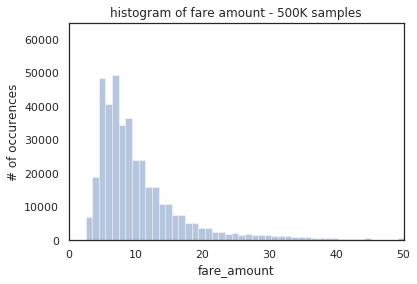

In [219]:
fig, ax = plt.subplots()
ax.axis([0,50,0,65000])
ax.set_title('histogram of fare amount - 500K samples')
ax.set_ylabel('# of occurences')
sns.distplot(train_df.fare_amount,ax=ax,kde=False,bins=50)

In [220]:
raw_data.fare_amount.std()

7.313368906314106

In [221]:
raw_data.fare_amount.median()

8.5

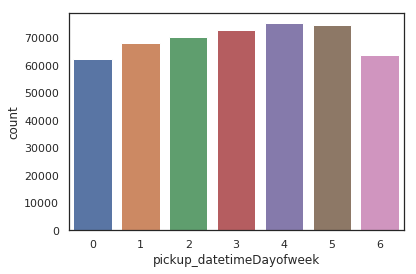

In [222]:
sns.countplot(x=raw_data.pickup_datetimeDayofweek)

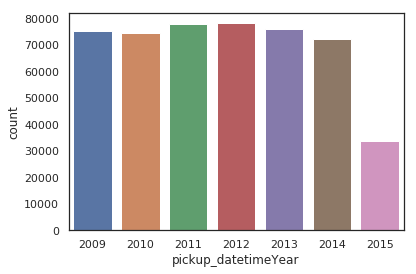

In [223]:
sns.countplot(x=raw_data.pickup_datetimeYear)

In [224]:
c = raw_data.corr()

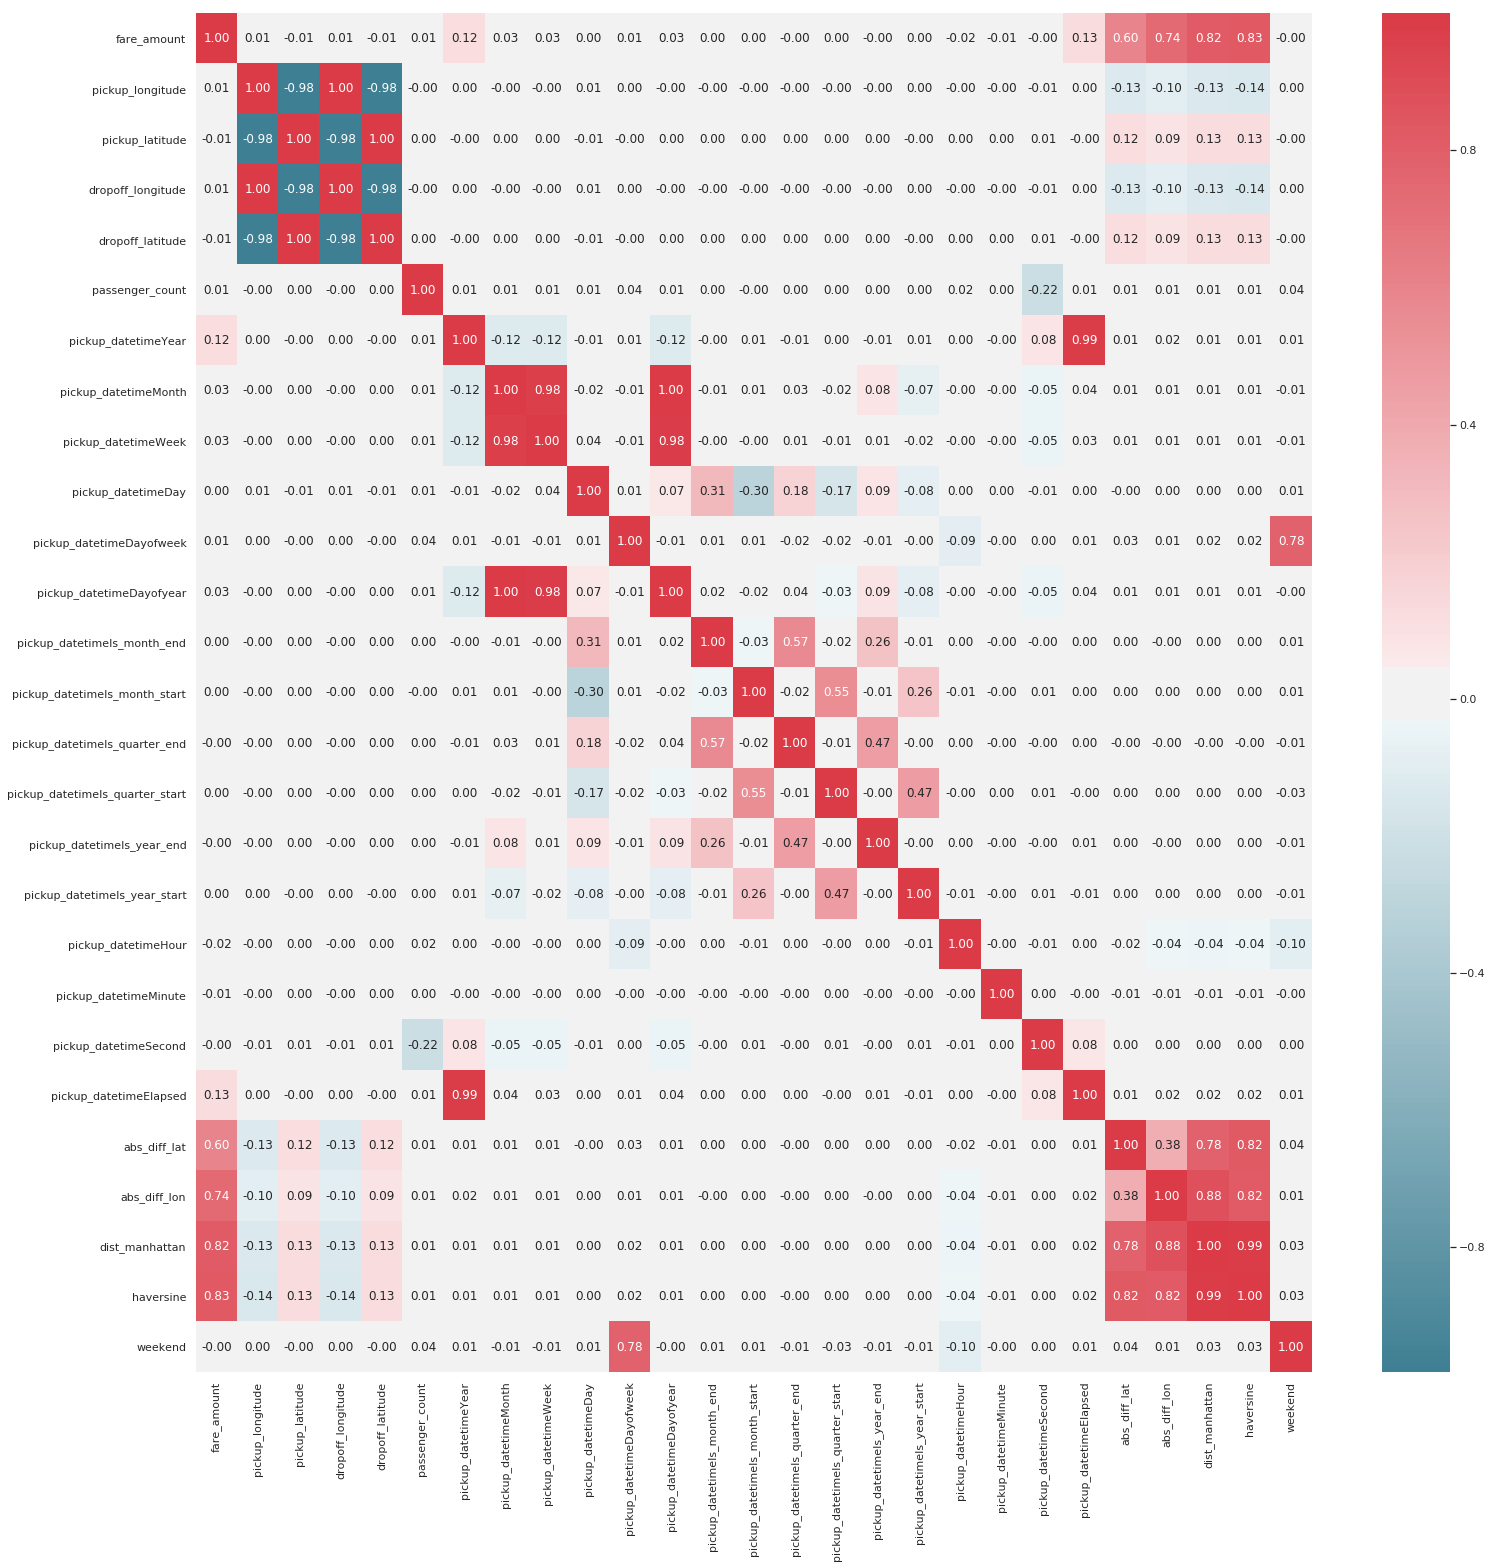

In [225]:
fig,ax = plt.subplots(figsize=(25,25))
sns.set(style='white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(c,cmap=cmap,ax=ax,annot=True,fmt='.2f',)

In [226]:
y_train = train_df.fare_amount
X_train = train_df.drop('fare_amount',axis='columns')

y_test = test_df.fare_amount
X_test = test_df.drop('fare_amount',axis='columns')

In [227]:
from sklearn.metrics import mean_squared_error

def rmse_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Linear Regression baseline

In [228]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
X_train_linreg = X_train.dist_manhattan.values.reshape(-1,1)
X_test_linreg = X_test.dist_manhattan.values.reshape(-1,1)
reg.fit(X=X_train_linreg,y=y_train)
y_hat = reg.predict(X_test_linreg)
error_linreg = rmse_error(y_test,y_hat)
print(f'Error from baseline model: linear regression =  {error_linreg:.2f}')

Error from baseline model: linear regression =  4.12


In [229]:
dist_corr = np.corrcoef(train_df.dist_manhattan,train_df.fare_amount)[0,1]


### Random Forest Model

In [288]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

reg = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_estimators=100,max_depth=30,n_jobs=-1,min_samples_leaf=1,verbose=1))
reg.fit(X_train,y_train)
y_hat_rf = reg.predict(X_test)
error_rf = rmse_error(y_test,y_hat_rf)
print(error_rf)

/home/ec2-user/SageMaker/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/SageMaker/envs/fastai/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished
/home/ec2-user/SageMaker/envs/fastai/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=4)]: Using backend ThreadingBacken

3.1207250463617813


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


### xgboost

In [295]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test)

In [290]:
#set parameters for xgboost
params = {'max_depth':20,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05
         }
num_rounds = 100

In [291]:
xgb_model = xgb.train(params,dtrain,num_rounds)

In [292]:
y_hat_xgb = xgb_model.predict(dtest)
rmse_xgb = rmse_error(y_test,y_hat_xgb)
print(rmse_xgb)

3.283198678812803


### Ensemble

In [293]:
y_hat = pd.DataFrame({
    'rf':y_hat_rf,
    'xgb':y_hat_xgb
})

In [298]:
y_hat_ensemble = np.mean(y_hat,axis='columns')
rmse_ensemble = rmse_error(y_test,y_hat_ensemble)
print(rmse_ensemble)

3.1146517612237683


### Deep Neural Network

### Kaggle submission

In [299]:
y_hat_kaggle_rf = reg.predict(kaggle)
y_hat_kaggle_xgb = xgb_model.predict(xgb.DMatrix(kaggle))

/home/ec2-user/SageMaker/envs/fastai/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [303]:
y_hat_kaggle = pd.DataFrame({
    'rf':y_hat_kaggle_rf,
    'xgb':y_hat_kaggle_xgb
})

In [304]:
y_hat_kaggle = np.mean(y_hat_kaggle,axis='columns')

In [306]:
kaggle_key = pd.read_csv('../data/taxi/test.csv').key

In [307]:
df_sub = pd.DataFrame({
    'key': kaggle_key,
    'fare_amount': y_hat_kaggle
}).set_index('key')

In [308]:
df_sub.to_csv('submission.csv')